# Train and Host a Keras Sequential Model
## Using Pipe Mode datasets and distributed training with Horovod
This notebook shows how to train and host a Keras Sequential model on SageMaker. The model used for this notebook is a simple deep CNN that was extracted from [the Keras examples](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py).

## The dataset
The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) is one of the most popular machine learning datasets. It consists of 60,000 32x32 images belonging to 10 different classes (6,000 images per class). Here are the classes in the dataset, as well as 10 random images from each:

![cifar10](https://maet3608.github.io/nuts-ml/_images/cifar10.png)

In this tutorial, we will train a deep CNN to recognize these images.

We'll compare trainig with file mode, pipe mode datasets and distributed training with Horovod

## Set up the environment

In [1]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

## Download the CIFAR-10 dataset
Downloading the test and training data takes around 5 minutes.

In [2]:
!python generate_cifar10_tfrecords.py --data-dir ./data


Download from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded cifar-10-python.tar.gz 170498071 bytes.
Generating ./data/train/train.tfrecords


Generating ./data/validation/validation.tfrecords
Generating ./data/eval/eval.tfrecords
Done!


## Create a training job using the sagemaker.TensorFlow estimator, running locally
To test that the code will work in SageMaker, we'll first use SageMaker local mode.

In [3]:
from sagemaker.tensorflow import TensorFlow

import subprocess
instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    instance_type = 'local_gpu'
    
local_hyperparameters = {'epochs': 2, 'batch-size' : 64}

source_dir = os.path.join(os.getcwd(), 'source_dir')
estimator = TensorFlow(entry_point='cifar10_keras_main.py',
                       source_dir=source_dir,
                       role=role,
                       framework_version='1.12.0',
                       py_version='py3',
                       hyperparameters=local_hyperparameters,
                       train_instance_count=1, train_instance_type=instance_type)

In [4]:
local_inputs = {'train' : 'file://'+os.getcwd()+'/data/train', 
                'validation' : 'file://'+os.getcwd()+'/data/validation', 
                'eval' : 'file://'+os.getcwd()+'/data/eval'}
estimator.fit(local_inputs)

Creating tmpzydpdw61_algo-1-3kdx6_1 ... 
Attaching to tmpzydpdw61_algo-1-3kdx6_12mdone
algo-1-3kdx6_1  | 2020-04-29 02:25:54,502 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-3kdx6_1  | 2020-04-29 02:25:54,757 sagemaker-containers INFO     Invoking user script
algo-1-3kdx6_1  | 
algo-1-3kdx6_1  | Training Env:
algo-1-3kdx6_1  | 
algo-1-3kdx6_1  | {
algo-1-3kdx6_1  |     "additional_framework_parameters": {},
algo-1-3kdx6_1  |     "channel_input_dirs": {
algo-1-3kdx6_1  |         "train": "/opt/ml/input/data/train",
algo-1-3kdx6_1  |         "validation": "/opt/ml/input/data/validation",
algo-1-3kdx6_1  |         "eval": "/opt/ml/input/data/eval"
algo-1-3kdx6_1  |     },
algo-1-3kdx6_1  |     "current_host": "algo-1-3kdx6",
algo-1-3kdx6_1  |     "framework_module": "sagemaker_tensorflow_container.training:main",
algo-1-3kdx6_1  |     "hosts": [
algo-1-3kdx6_1  |         "algo-1-3kdx6"
algo-1-3kdx6_1  |     ],
algo-1-3kdx6_1  |     "hyper

## Run on SageMaker cloud

### Uploading the data to s3

In [5]:
dataset_location = sagemaker_session.upload_data(path='data', key_prefix='data/DEMO-cifar10-tf')
display(dataset_location)

's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf'

### Configuring metrics from the job logs
SageMaker can get training metrics directly from the logs and send them to CloudWatch metrics.

In [6]:
keras_metric_definition = [
    {'Name': 'train:loss', 'Regex': '.*loss: ([0-9\\.]+) - acc: [0-9\\.]+.*'},
    {'Name': 'train:accuracy', 'Regex': '.*loss: [0-9\\.]+ - acc: ([0-9\\.]+).*'},
    {'Name': 'validation:accuracy', 'Regex': '.*step - loss: [0-9\\.]+ - acc: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_acc: ([0-9\\.]+).*'},
    {'Name': 'validation:loss', 'Regex': '.*step - loss: [0-9\\.]+ - acc: [0-9\\.]+ - val_loss: ([0-9\\.]+) - val_acc: [0-9\\.]+.*'},
    {'Name': 'sec/steps', 'Regex': '.* - \d+s (\d+)[mu]s/step - loss: [0-9\\.]+ - acc: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_acc: [0-9\\.]+'}
]

### Train image classification based on the cifar10 dataset

In [7]:
hyperparameters = {'epochs': 10, 'batch-size' : 256}

In [8]:
from sagemaker.tensorflow import TensorFlow


source_dir = os.path.join(os.getcwd(), 'source_dir')
estimator = TensorFlow(base_job_name='cifar10-tf',
                       entry_point='cifar10_keras_main.py',
                       source_dir=source_dir,
                       role=role,
                       framework_version='1.12.0',
                       py_version='py3',
                       hyperparameters=hyperparameters,
                       train_instance_count=1, train_instance_type='ml.p3.2xlarge',
                       tags = [{'Key' : 'Project', 'Value' : 'cifar10'},{'Key' : 'TensorBoard', 'Value' : 'file'}],
                       metric_definitions=keras_metric_definition)

In [9]:
remote_inputs = {'train' : dataset_location+'/train', 'validation' : dataset_location+'/validation', 'eval' : dataset_location+'/eval'}
estimator.fit(remote_inputs, wait=True)

2020-04-29 02:27:40 Starting - Starting the training job...
2020-04-29 02:27:42 Starting - Launching requested ML instances......
2020-04-29 02:28:51 Starting - Preparing the instances for training......
2020-04-29 02:30:00 Downloading - Downloading input data...
2020-04-29 02:30:41 Training - Downloading the training image...
2020-04-29 02:31:02 Training - Training image download completed. Training in progress..2020-04-29 02:31:06,368 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-04-29 02:31:07,522 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "eval": "/opt/ml/input/data/eval",
        "validation": "/opt/ml/input/data/validation",
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparame

### View the job training metrics
SageMaker used the regular expression configured above, to send the job metrics to CloudWatch metrics.
You can now view the job metrics directly from the SageMaker console.  

login to the [SageMaker console](https://console.aws.amazon.com/sagemaker/home) choose the latest training job, scroll down to the monitor section.  
Using CloudWatch metrics, you can change the period and configure the statistics

In [10]:
from IPython.core.display import Markdown

link = 'https://console.aws.amazon.com/cloudwatch/home?region='+sagemaker_session.boto_region_name+'#metricsV2:query=%7B/aws/sagemaker/TrainingJobs,TrainingJobName%7D%20'+estimator.latest_training_job.job_name
display(Markdown('CloudWatch metrics: [link]('+link+')'))
display(Markdown('After you choose a metric, change the period to 1 Minute (Graphed Metrics -> Period)'))

CloudWatch metrics: [link](https://console.aws.amazon.com/cloudwatch/home?region=us-east-1#metricsV2:query=%7B/aws/sagemaker/TrainingJobs,TrainingJobName%7D%20cifar10-tf-2020-04-29-02-27-40-012)

After you choose a metric, change the period to 1 Minute (Graphed Metrics -> Period)

## Run on SageMaker with Pipe Mode input
SageMaker Pipe Mode is a mechanism for providing S3 data to a training job via Linux fifos. Training programs can read from the fifo and get high-throughput data transfer from S3, without managing the S3 access in the program itself.
Pipe Mode is covered in more detail in the SageMaker [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html#your-algorithms-training-algo-running-container-inputdataconfig)

in out script, we enabled Pipe Mode using the following code:
```python
from sagemaker_tensorflow import PipeModeDataset
dataset = PipeModeDataset(channel=channel_name, record_format='TFRecord')
```

In [11]:
from sagemaker.tensorflow import TensorFlow


source_dir = os.path.join(os.getcwd(), 'source_dir')
estimator_pipe = TensorFlow(base_job_name='pipe-cifar10-tf',
                       entry_point='cifar10_keras_main.py',
                       source_dir=source_dir,
                       role=role,
                       framework_version='1.12.0',
                       py_version='py3',
                       hyperparameters=hyperparameters,
                       train_instance_count=1, train_instance_type='ml.p3.2xlarge',
                       tags = [{'Key' : 'Project', 'Value' : 'cifar10'},{'Key' : 'TensorBoard', 'Value' : 'pipe'}],
                       metric_definitions=keras_metric_definition,
                       input_mode='Pipe')

In this example, we set ```wait=False``` if you want to see the output logs, change this to ```wait=True```

In [12]:
remote_inputs = {'train' : dataset_location+'/train/train.tfrecords', 'validation' : dataset_location+'/validation', 'eval' : dataset_location+'/eval'}
estimator_pipe.fit(remote_inputs, wait=False)

Note that we specified the exact filename of training data rather than just the folder name.

## Distributed training with Horovod
Horovod is a distributed training framework based on MPI. Horovod is only available with TensorFlow version 1.12 or newer. You can find more details at [Horovod README](https://github.com/horovod/horovod/blob/master/README.rst).

To enable Horovod, we need to add the following code to our script:
```python
import horovod.keras as hvd
hvd.init()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = str(hvd.local_rank())
K.set_session(tf.Session(config=config))
```

Add the following callbacks:
```python
hvd.callbacks.BroadcastGlobalVariablesCallback(0)
hvd.callbacks.MetricAverageCallback()
```

Configure the optimizer:
```python
opt = Adam(lr=learning_rate * size, decay=weight_decay)
opt = hvd.DistributedOptimizer(opt)
```
Choose to save checkpoints and send TensorBoard logs only from the ```python hvd.rank() == 0``` instance.

To start a distributed training job with Horovod, configure the job distribution:
```python
distributions = {'mpi': {
                    'enabled': True,
                    'processes_per_host': # Number of Horovod processes per host
                        }
                }
```

In [13]:
from sagemaker.tensorflow import TensorFlow

train_instance_type='ml.p3.8xlarge'
train_instance_count = 1
gpus_per_host = 4

num_of_shards = gpus_per_host * train_instance_count

In [14]:
distributions = {'mpi': {
                    'enabled': True,
                    'processes_per_host': gpus_per_host
                        }
                }

keras_metric_definition = [
    {'Name': 'train:loss', 'Regex': '.*loss: ([0-9\\.]+) - acc: [0-9\\.]+.*'},
    {'Name': 'train:accuracy', 'Regex': '.*loss: [0-9\\.]+ - acc: ([0-9\\.]+).*'},
    {'Name': 'validation:accuracy', 'Regex': '.*step - loss: [0-9\\.]+ - acc: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_acc: ([0-9\\.]+).*'},
    {'Name': 'validation:loss', 'Regex': '.*step - loss: [0-9\\.]+ - acc: [0-9\\.]+ - val_loss: ([0-9\\.]+) - val_acc: [0-9\\.]+.*'},
    {'Name': 'sec/steps', 'Regex': '.* - \d+s (\d+)[mu]s/step - loss: [0-9\\.]+ - acc: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_acc: [0-9\\.]+'}
]

hyperparameters = {'epochs': 20, 'batch-size' : 256}

input_mode = 'File'

In [15]:
%load_ext autoreload
%autoreload 2

from shard import do_shard

def shard_data_and_upload(local_data_dir, num_of_shards):
    do_shard(local_data_dir, num_of_shards)
    dataset_location = sagemaker_session.upload_data(path='data', key_prefix='data/DEMO-cifar10-tf')
    display(dataset_location)
    
    remote_inputs = {}

    for idx in range(num_of_shards):
        train_channel_name = 'train_{}'.format(idx)
        train_channel_location = '{}/train/{}'.format(dataset_location, idx)
        remote_inputs[train_channel_name] = train_channel_location
        
        remote_inputs['validation_{}'.format(idx)] = '{}/validation'.format(dataset_location)

    remote_inputs['validation'] = '{}/validation'.format(dataset_location)
    remote_inputs['eval'] = '{}/eval'.format(dataset_location)
    
    return remote_inputs

### Data split for Horovod and upload to S3

For Horovod, we need a dedicated input channel for each Horovod worker. In this example, we will use a instance with 4 GPUs (**ml.p3.8xlarge**). So we will shard the train data into four tfrecord files as below.

In [16]:
remote_inputs = shard_data_and_upload('./data', num_of_shards)


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Generating ./data/train/0/train_0.tfrecords
Generating ./data/train/1/train_1.tfrecords
Generating ./data/train/2/train_2.tfrecords
Generating ./data/train/3/train_3.tfrecords


's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf'

In [33]:
remote_inputs

{'train_0': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/train/0',
 'validation_0': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/validation',
 'train_1': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/train/1',
 'validation_1': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/validation',
 'train_2': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/train/2',
 'validation_2': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/validation',
 'train_3': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/train/3',
 'validation_3': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/validation',
 'validation': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/validation',
 'eval': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/eval'}

In [17]:
source_dir = os.path.join(os.getcwd(), 'source_dir')
estimator_dist = TensorFlow(base_job_name='horovod-cifar10-tf',
                       entry_point='cifar10_keras_main-tf2.py',
                       source_dir=source_dir,
                       role=role,
                       framework_version='2.1.0',
                       py_version='py3',
                       hyperparameters=hyperparameters,
                       train_instance_count=train_instance_count,
                       train_instance_type=train_instance_type,
                       tags = [{'Key' : 'Project', 'Value' : 'cifar10'},{'Key' : 'TensorBoard', 'Value' : 'horovod'}],
                       metric_definitions=keras_metric_definition,
                       distributions=distributions,
                       input_mode=input_mode)

In this example, we set ```wait=False``` if you want to see the output logs, change this to ```wait=True```

In [18]:
estimator_dist.fit(remote_inputs, wait=True)

2020-04-29 02:34:12 Starting - Starting the training job...
2020-04-29 02:34:15 Starting - Launching requested ML instances......
2020-04-29 02:35:18 Starting - Preparing the instances for training......
2020-04-29 02:36:38 Downloading - Downloading input data
2020-04-29 02:36:38 Training - Downloading the training image.........
2020-04-29 02:38:08 Training - Training image download completed. Training in progress..2020-04-29 02:38:12,424 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-04-29 02:38:13,346 sagemaker-containers INFO     Starting MPI run as worker node.
2020-04-29 02:38:13,346 sagemaker-containers INFO     Creating SSH daemon.
2020-04-29 02:38:13,352 sagemaker-containers INFO     Waiting for MPI workers to establish their SSH connections
2020-04-29 02:38:13,352 sagemaker-containers INFO     Env Hosts: ['algo-1'] Hosts: ['algo-1:4'] process_per_hosts: 4 num_processes: 4
2020-04-29 02:38:13,353 sagemaker-containers INFO     Netw

## Distributed training with Horovod and Pipe Mode input
Ditributed training with Horovod can also utilize SageMaker Pipe Mode.

In [19]:
from sagemaker.tensorflow import TensorFlow

train_instance_type='ml.p3.8xlarge'
train_instance_count = 1
gpus_per_host = 4

num_of_shards = gpus_per_host * train_instance_count

In [20]:
distributions = {'mpi': {
                    'enabled': True,
                    'processes_per_host': gpus_per_host
                        }
                }

keras_metric_definition = [
    {'Name': 'train:loss', 'Regex': '.*loss: ([0-9\\.]+) - acc: [0-9\\.]+.*'},
    {'Name': 'train:accuracy', 'Regex': '.*loss: [0-9\\.]+ - acc: ([0-9\\.]+).*'},
    {'Name': 'validation:accuracy', 'Regex': '.*step - loss: [0-9\\.]+ - acc: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_acc: ([0-9\\.]+).*'},
    {'Name': 'validation:loss', 'Regex': '.*step - loss: [0-9\\.]+ - acc: [0-9\\.]+ - val_loss: ([0-9\\.]+) - val_acc: [0-9\\.]+.*'},
    {'Name': 'sec/steps', 'Regex': '.* - \d+s (\d+)[mu]s/step - loss: [0-9\\.]+ - acc: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_acc: [0-9\\.]+'}
]

hyperparameters = {'epochs': 20, 'batch-size' : 256}

input_mode = 'Pipe'

In [21]:
%load_ext autoreload
%autoreload 2

from shard import do_shard

def shard_data_and_upload(local_data_dir, num_of_shards):
    do_shard(local_data_dir, num_of_shards)
    dataset_location = sagemaker_session.upload_data(path='data', key_prefix='data/DEMO-cifar10-tf')
    display(dataset_location)
    
    remote_inputs = {}

    for idx in range(num_of_shards):
        train_channel_name = 'train_{}'.format(idx)
        train_channel_location = '{}/train/{}'.format(dataset_location, idx)
        remote_inputs[train_channel_name] = train_channel_location
        
        remote_inputs['validation_{}'.format(idx)] = '{}/validation'.format(dataset_location)

    remote_inputs['validation'] = '{}/validation'.format(dataset_location)
    remote_inputs['eval'] = '{}/eval'.format(dataset_location)
    
    return remote_inputs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
remote_inputs = shard_data_and_upload('./data', num_of_shards)

Generating ./data/train/0/train_0.tfrecords
Generating ./data/train/1/train_1.tfrecords
Generating ./data/train/2/train_2.tfrecords
Generating ./data/train/3/train_3.tfrecords


's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf'

In [34]:
remote_inputs

{'train_0': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/train/0',
 'validation_0': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/validation',
 'train_1': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/train/1',
 'validation_1': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/validation',
 'train_2': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/train/2',
 'validation_2': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/validation',
 'train_3': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/train/3',
 'validation_3': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/validation',
 'validation': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/validation',
 'eval': 's3://sagemaker-us-east-1-637338777613/data/DEMO-cifar10-tf/eval'}

In [23]:
source_dir = os.path.join(os.getcwd(), 'source_dir')
estimator_dist = TensorFlow(base_job_name='horovod-pipe-cifar10-tf',
                       entry_point='cifar10_keras_main-tf2.py',
                       source_dir=source_dir,
                       role=role,
                       framework_version='2.1.0',
                       py_version='py3',
                       hyperparameters=hyperparameters,
                       train_instance_count=train_instance_count,
                       train_instance_type=train_instance_type,
                       tags = [{'Key' : 'Project', 'Value' : 'cifar10'},{'Key' : 'TensorBoard', 'Value' : 'horovod-pipe'}],
                       metric_definitions=keras_metric_definition,
                       distributions=distributions,
                       input_mode=input_mode)

In [24]:
estimator_dist.fit(remote_inputs, wait=True)

2020-04-29 02:40:16 Starting - Starting the training job...
2020-04-29 02:40:19 Starting - Launching requested ML instances.........
2020-04-29 02:41:54 Starting - Preparing the instances for training.........
2020-04-29 02:43:30 Downloading - Downloading input data
2020-04-29 02:43:30 Training - Downloading the training image.........
2020-04-29 02:44:59 Training - Training image download completed. Training in progress.2020-04-29 02:45:03,657 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-04-29 02:45:04,048 sagemaker-containers INFO     Starting MPI run as worker node.
2020-04-29 02:45:04,048 sagemaker-containers INFO     Creating SSH daemon.
2020-04-29 02:45:04,053 sagemaker-containers INFO     Waiting for MPI workers to establish their SSH connections
2020-04-29 02:45:04,053 sagemaker-containers INFO     Env Hosts: ['algo-1'] Hosts: ['algo-1:4'] process_per_hosts: 4 num_processes: 4
2020-04-29 02:45:04,055 sagemaker-containers INFO    

### Local TensorBoard command
Using TensorBoard we can compare the jobs we ran. The following command prints the TensorBoard command.
Run it in any environment where you have TensorBoard installed.  

In [25]:
!python generate_tensorboard_command.py

AWS_REGION=us-east-1 tensorboard --logdir horovod-pipe:"s3://sagemaker-us-east-1-637338777613/horovod-pipe-cifar10-tf-2020-04-29-02-40-16-420/model",horovod:"s3://sagemaker-us-east-1-637338777613/horovod-cifar10-tf-2020-04-29-02-34-12-249/model",pipe:"s3://sagemaker-us-east-1-637338777613/pipe-cifar10-tf-2020-04-29-02-33-23-861/model",file:"s3://sagemaker-us-east-1-637338777613/cifar10-tf-2020-04-29-02-27-40-012/model"


You can install [TensorBoard](https://github.com/tensorflow/tensorboard) locally using `pip install tensorboard`.  
To access an S3 log directory, configure the TensorBoard default region. You can do this by configuring an environment variable named AWS_REGION, and setting the value of the environment variable to the AWS region your training jobs run in.  
For example, `export AWS_REGION = 'us-east-1'`

You can access TensorBoard locally at http://localhost:6006

Based on the TensorBoard metrics, we can see that:
1. All jobs run for 10 epochs (0 - 9).
2. File mode and Pipe mode runs for ~1 minute - Pipemode doesn't effect training performance.
3. Distributed mode runs for 45 seconds.
4. All of the training jobs resulted in similar validation accuracy.

This example uses a small dataset (179 MB). For larger datasets, pipemode can significantly reduce training time because it does not copy the entire dataset into local memory.

## Deploy the trained model

The deploy() method creates an endpoint that serves prediction requests in real-time.
The model saves keras artifacts, to use TensorFlow serving for deployment, you'll need to save the artifacts in SavedModel format.

We are using the solutions from the [deploy trained keras or tensorflow models using amazon sagemaker](https://aws.amazon.com/blogs/machine-learning/deploy-trained-keras-or-tensorflow-models-using-amazon-sagemaker/) blog post.

In [26]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-----------!

## Make some predictions
To verify the that the endpoint functions properly, we generate random data in the correct shape and get a prediction.

In [27]:
# Creating fake prediction data
import numpy as np
data = np.random.randn(1, 32, 32, 3)
print("Predicted class is {}".format(np.argmax(predictor.predict(data)['predictions'])))

Predicted class is 8


### Calculating accuracy and create a confusion matrix based on the test dataset

Our endpoint works as expected, we'll now use the test dataset for predictions and calculate our model accuracy

In [28]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
datagen = ImageDataGenerator()

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

def predict(data):
    predictions = predictor.predict(data)['predictions']
    return predictions

Using TensorFlow backend.


In [29]:
batch_size = 128
predicted = []
actual = []
batches = 0
for data in datagen.flow(x_test,y_test,batch_size=batch_size):
    for i,prediction in enumerate(predict(data[0])):
        predicted.append(np.argmax(prediction))
        actual.append(data[1][i][0])
    batches += 1
    if batches >= len(x_test) / batch_size:
        break

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(y_pred=predicted,y_true=actual)
display('Average accuracy: {}%'.format(round(accuracy*100,2)))

'Average accuracy: 72.18%'

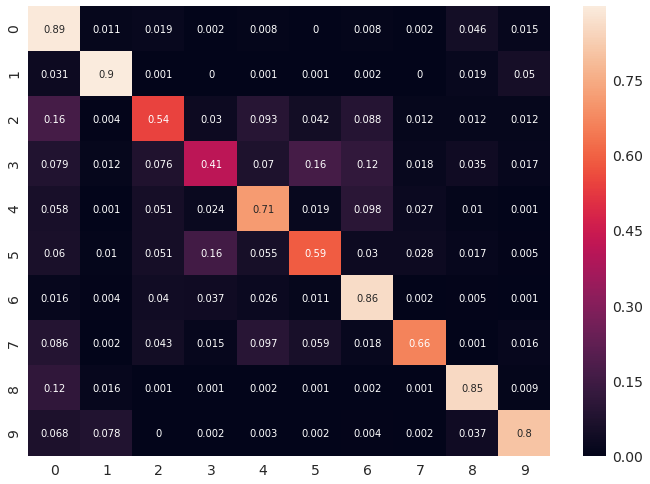

In [31]:
%matplotlib inline
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_pred=predicted,y_true=actual)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.set(font_scale=1.4)#for label size
sn.heatmap(cm, annot=True,annot_kws={"size": 10})# font size

Using this heatmap we can calculate the accuracy of each one of the labels

# Cleaning up
To avoid incurring charges to your AWS account for the resources used in this tutorial you need to delete the SageMaker Endpoint:

In [32]:
sagemaker_session.delete_endpoint(predictor.endpoint)